In [1]:
import pickle
import random
import sklearn

import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, GridSearchCV

from imblearn.over_sampling import SMOTE

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

from sklearn.metrics import make_scorer, accuracy_score, recall_score, confusion_matrix, RocCurveDisplay, ConfusionMatrixDisplay

In [2]:
df = pd.read_csv("land-mines-detection-dataset.csv")
df = df.rename(columns={"V": "Voltage", "H": "Height", "S": "Soil Type", "M" : "Mine Type"})
df.shape

(338, 4)

In [3]:
df_to_display = df.rename(columns={"Voltage": "Voltagem", "Height": "Altura",
                                   "Soil Type": "Tipo de Solo", "Mine Type" : "Tipo de Mina"})
random_rows = df_to_display.sample(frac=1)
random_rows.head(10)

,Voltagem,Altura,Tipo de Solo,Tipo de Mina
16,0.315347,0.000000,2,1
291,0.522658,0.363636,6,3
189,0.314199,1.000000,1,5
63,0.719032,0.000000,2,2
44,0.292205,0.545455,6,1
309,0.223565,0.272727,3,4
52,0.610271,0.636364,1,2
323,0.369003,0.909091,4,5
59,0.655588,0.545455,4,2
268,0.993956,0.090909,6,2


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338 entries, 0 to 337
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Voltage    338 non-null    float64
 1   Height     338 non-null    float64
 2   Soil Type  338 non-null    int64  
 3   Mine Type  338 non-null    int64  
dtypes: float64(2), int64(2)
memory usage: 10.7 KB


In [5]:
df.describe()

,Voltage,Height,Soil Type,Mine Type
count,338.000000,338.000000,338.000000,338.000000
mean,0.430634,0.508876,3.517751,2.952663
std,0.195819,0.306043,1.721218,1.419703
min,0.197734,0.000000,1.000000,1.000000
25%,0.309737,0.272727,2.000000,2.000000
50%,0.359516,0.545455,4.000000,3.000000
75%,0.482628,0.727273,5.000000,4.000000
max,0.999999,1.000000,6.000000,5.000000


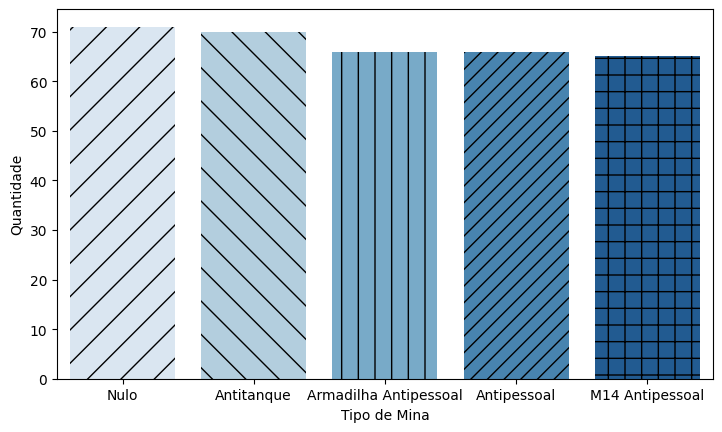

In [6]:
ax = sns.countplot(x="Mine Type", data=df, palette="Blues")

hatches = ["/", "\\", "|", "//", "+"]
for i, bar in enumerate(ax.patches):
    bar.set_hatch(hatches[i % len(hatches)])

ax.set_xlabel('Tipo de Mina')
ax.set_ylabel('Quantidade')

new_labels = ['Nulo', 'Antitanque', 'Armadilha Antipessoal', 'Antipessoal', 'M14 Antipessoal']
ax.set_xticks(range(len(new_labels)))
ax.set_xticklabels(new_labels)

plt.subplots_adjust(right=1.15)

plt.show()

## Buscando os Melhores Parâmetros para o Modelo

In [7]:
df_corr = df.corr()
display(df_corr)

,Voltage,Height,Soil Type,Mine Type
Voltage,1.000000,-0.377523,0.070673,-0.144569
Height,-0.377523,1.000000,-0.006957,0.041326
Soil Type,0.070673,-0.006957,1.000000,0.017346
Mine Type,-0.144569,0.041326,0.017346,1.000000


In [8]:
new_labels = ["Voltagem", "Altura", "Tipo de Solo", "Tipo de Mina"]

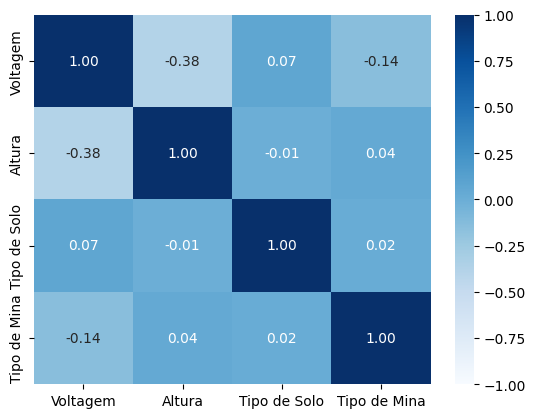

In [9]:
heatmap = sns.heatmap(df_corr, annot=True, fmt=".2f", vmax=1, vmin=-1, cmap="Blues")

heatmap.set_xticklabels(new_labels)
heatmap.set_yticklabels(new_labels)

plt.show()

In [10]:
df_cov = df.cov()
display(df_cov)

,Voltage,Height,Soil Type,Mine Type
Voltage,0.038345,-0.022625,0.023820,-0.040191
Height,-0.022625,0.093663,-0.003665,0.017956
Soil Type,0.023820,-0.003665,2.962592,0.042386
Mine Type,-0.040191,0.017956,0.042386,2.015557


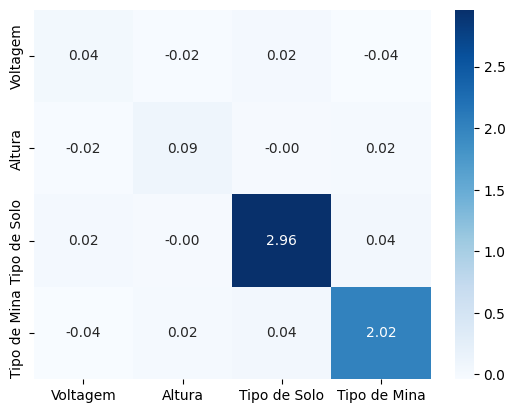

In [11]:
heatmap = sns.heatmap(df_cov, fmt='.2f', annot=True, cmap="Blues")

heatmap.set_xticklabels(new_labels)
heatmap.set_yticklabels(new_labels)

plt.show()

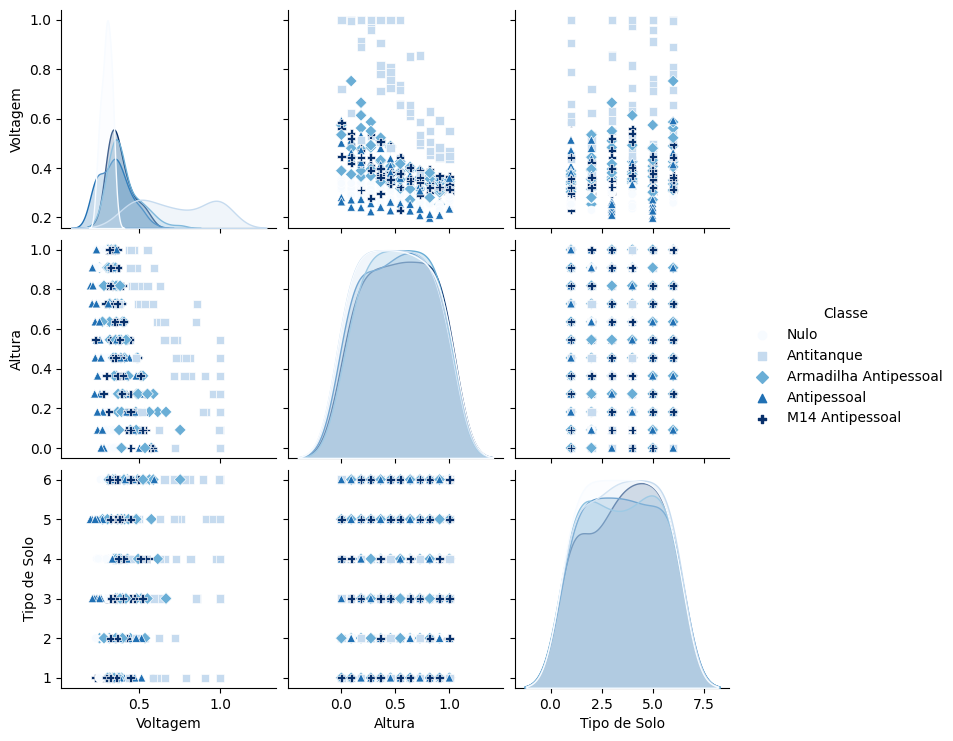

In [12]:
mine_type_markers = {
    1: "o",
    2: "s",
    3: "D",
    4: "^",
    5: "P"
}

new_legend_labels = {
    1: 'Nulo',
    2: 'Antitanque',
    3: 'Armadilha Antipessoal',
    4: "Antipessoal",
    5: 'M14 Antipessoal'
}

df_plot = df.copy()
df_plot.rename(columns={"Voltage": "Voltagem",
                        "Height": "Altura",
                        "Soil Type": "Tipo de Solo"
                       }, inplace=True)


pair = sns.pairplot(df_plot, hue="Mine Type", markers=mine_type_markers, palette="Blues")
for t, l in zip(pair._legend.texts, new_legend_labels.values()):
    t.set_text(l)
pair._legend.set_title('Classe')
pair._legend.set_bbox_to_anchor((1.15, 0.5))

plt.show()

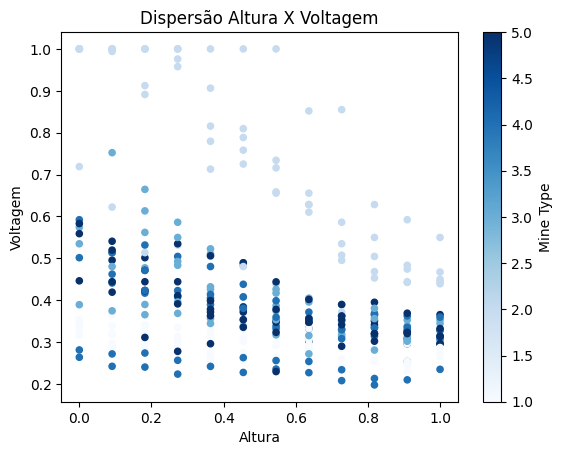

In [13]:
df.plot.scatter(x="Height", y="Voltage", c="Mine Type", colormap="Blues")
plt.xlabel('Altura')
plt.ylabel('Voltagem')
plt.title("Dispersão Altura X Voltagem")

plt.show()

In [14]:
X = df[["Voltage", "Height", "Soil Type"]].to_numpy()
y = df["Mine Type"]

model = ExtraTreesClassifier()
model.fit(X,y)

print(model.feature_importances_)

[0.80670362 0.1088805  0.08441588]


## Análise preliminar dos melhores modelos

In [15]:
np.random.seed(42)

In [16]:
recall_scorer = make_scorer(recall_score, average='macro')

In [17]:
model = {
    "KNN": (KNeighborsClassifier(), {"n_neighbors": [3,5,7]}),
    "Tree": (DecisionTreeClassifier(), {"max_depth": [3,5,7], "criterion": ["gini", "entropy"]}),
    "SVM": (SVC(), {"degree": [3,6,8], "kernel": ["linear", "rbf"]}),
    "RandomForest": (RandomForestClassifier(), {"n_estimators": [100,500,1000], "max_depth": [3,5,7], "criterion": ["gini", "entropy"]})
}

In [18]:
X = df[["Voltage", "Height", "Soil Type"]].to_numpy()
y = df["Mine Type"]

kf = StratifiedKFold()

for model_name, (clf, parameters) in model.items():
    means = {'accuracy': [], 'recall': []}
    
    for fold, (train,test) in enumerate(kf.split(X,y)):
        best = GridSearchCV(clf, parameters, n_jobs=-1, cv=kf, scoring=recall_scorer, return_train_score=True)
        best.fit(X[train], y[train])
        
        y_pred = best.predict(X[test])
        
        means['accuracy'].append(accuracy_score(y[test], y_pred))
        means['recall'].append(recall_score(y[test], y_pred, average='macro'))
        
        print(f"{fold+1} -- {model_name} -- \
        acc: {round(means['accuracy'][-1] * 100, 2)}% rec: {round(means['recall'][-1] * 100, 2)}% Best parameters {best.best_params_}")
    
    print(f"\n\tA média de acuracia do {model_name} foi de {sum(means['accuracy'])/len(means['accuracy'])*100}%")
    print(f"\tA média de recall do {model_name} foi de {sum(means['recall'])/len(means['recall'])*100}%")
    print("--------------------------------")

1 -- KNN --         acc: 52.94% rec: 50.77% Best parameters {'n_neighbors': 3}
2 -- KNN --         acc: 36.76% rec: 36.15% Best parameters {'n_neighbors': 5}
3 -- KNN --         acc: 55.88% rec: 55.38% Best parameters {'n_neighbors': 5}
4 -- KNN --         acc: 53.73% rec: 52.64% Best parameters {'n_neighbors': 3}
5 -- KNN --         acc: 64.18% rec: 63.3% Best parameters {'n_neighbors': 5}

	A média de acuracia do KNN foi de 52.69973661106234%
	A média de recall do KNN foi de 51.64835164835164%
--------------------------------
1 -- Tree --         acc: 54.41% rec: 52.72% Best parameters {'criterion': 'entropy', 'max_depth': 7}
2 -- Tree --         acc: 48.53% rec: 47.8% Best parameters {'criterion': 'entropy', 'max_depth': 7}
3 -- Tree --         acc: 54.41% rec: 54.18% Best parameters {'criterion': 'gini', 'max_depth': 7}
4 -- Tree --         acc: 46.27% rec: 45.49% Best parameters {'criterion': 'gini', 'max_depth': 5}
5 -- Tree --         acc: 58.21% rec: 57.25% Best parameters {'cr

# Transformando o Dataset
Realizando uma modificação para ficar apenas dois rótulos. 0 = Não mina e 1 = Mina

In [19]:
aux = df["Mine Type"].replace({1: 0, 2: 1, 3: 1, 4: 1, 5: 1})

X = df[["Voltage", "Height", "Soil Type"]]
y = aux

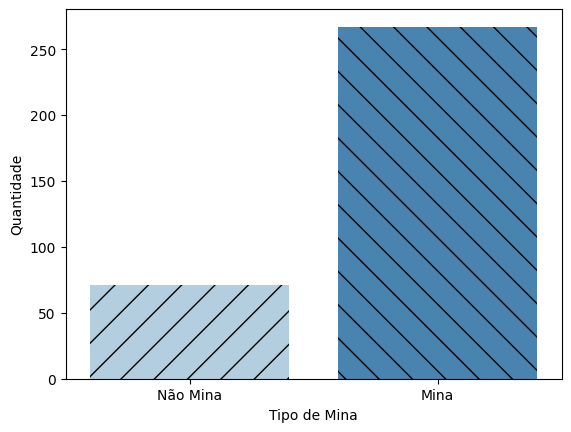

In [20]:
ax = sns.countplot(x="Mine Type", data=pd.concat([X,y], axis=1), palette="Blues")

hatches = ["/", "\\"]
for i, bar in enumerate(ax.patches):
    bar.set_hatch(hatches[i % len(hatches)])

ax.set_xlabel('Tipo de Mina')
ax.set_ylabel('Quantidade')

new_xlabels = ['Não Mina', 'Mina']
ax.set_xticks(range(len(new_xlabels)))
ax.set_xticklabels(new_xlabels)

plt.show()

# Balanceando o Dataset utilizando o algoritmo SMOTE

In [21]:
smt = SMOTE(random_state=42)
X,y = smt.fit_resample(X,y)
new_df = pd.concat([X,y], axis=1)
new_df.shape

(534, 4)

In [22]:
new_df.head(200)

,Voltage,Height,Soil Type,Mine Type
0,0.338157,0.000000,1,0
1,0.320241,0.181818,1,0
2,0.287009,0.272727,1,0
3,0.256284,0.454545,1,0
4,0.262840,0.545455,1,0
...,...,...,...,...
195,0.389728,0.727273,4,1
196,0.395045,0.818182,4,1
197,0.365558,1.000000,4,1
198,0.422960,0.181818,2,1


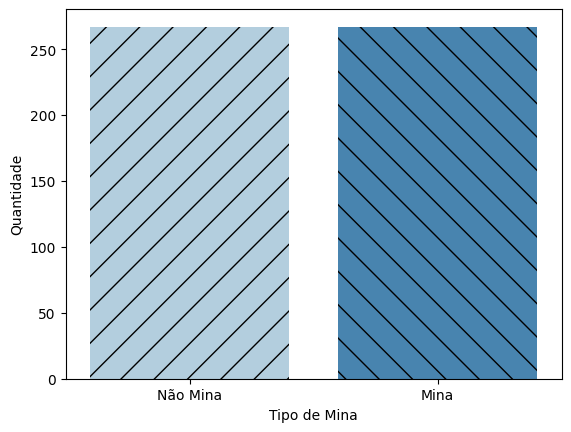

In [23]:
ax = sns.countplot(x="Mine Type", data=new_df, palette="Blues")

hatches = ["/", "\\"]
for i, bar in enumerate(ax.patches):
    bar.set_hatch(hatches[i % len(hatches)])

ax.set_xlabel('Tipo de Mina')
ax.set_ylabel('Quantidade')

new_xlabels = ['Não Mina', 'Mina']
ax.set_xticks(range(len(new_xlabels)))
ax.set_xticklabels(new_xlabels)

plt.show()

In [24]:
new_df_corr = new_df.corr()
display(new_df_corr)

,Voltage,Height,Soil Type,Mine Type
Voltage,1.000000,-0.291987,0.056154,0.498624
Height,-0.291987,1.000000,-0.008520,0.059402
Soil Type,0.056154,-0.008520,1.000000,-0.012067
Mine Type,0.498624,0.059402,-0.012067,1.000000


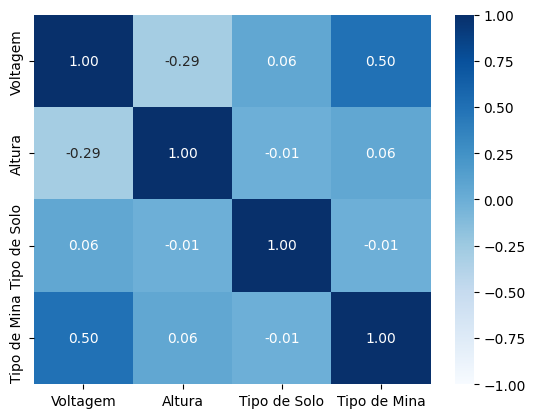

In [25]:
heatmap = sns.heatmap(new_df_corr, annot=True, fmt=".2f", vmax=1, vmin=-1, cmap="Blues")

heatmap.set_xticklabels(new_labels)
heatmap.set_yticklabels(new_labels)

plt.show()

In [26]:
new_df_cov = new_df.cov()
display(new_df_cov)

,Voltage,Height,Soil Type,Mine Type
Voltage,0.028643,-0.014541,0.016238,0.042234
Height,-0.014541,0.086586,-0.004283,0.008748
Soil Type,0.016238,-0.004283,2.919384,-0.010319
Mine Type,0.042234,0.008748,-0.010319,0.250469


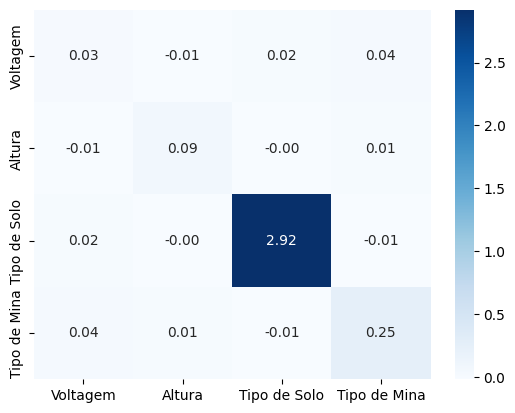

In [27]:
heatmap = sns.heatmap(new_df_cov, fmt='.2f', annot=True, cmap="Blues")

heatmap.set_xticklabels(new_labels)
heatmap.set_yticklabels(new_labels)

plt.show()

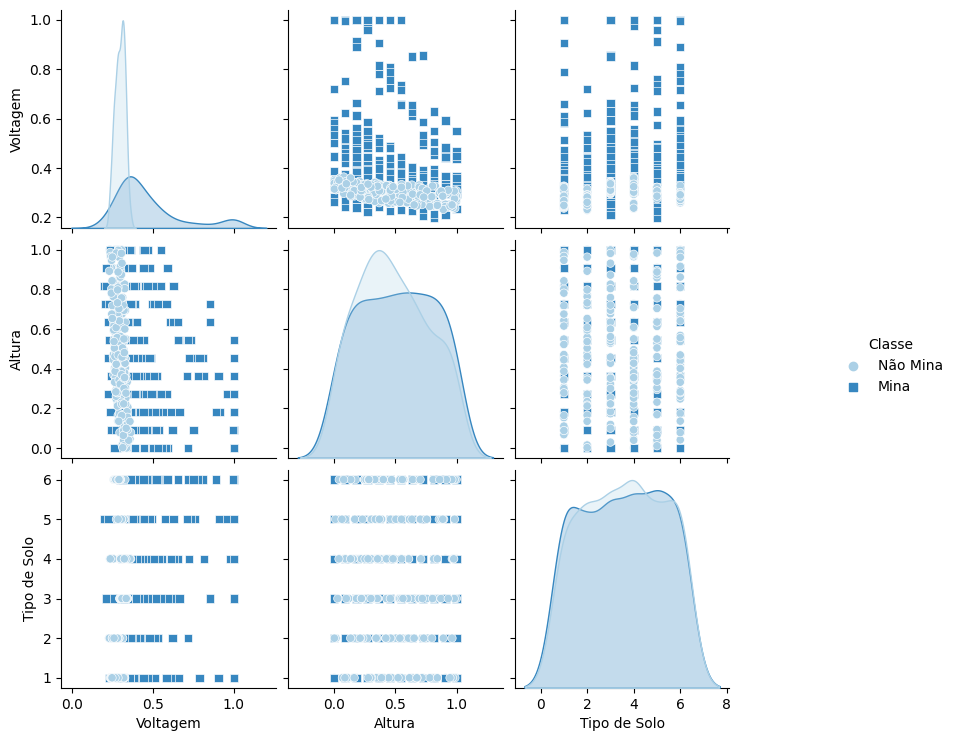

In [28]:
mine_type_markers = {
    0: "o",
    1: "s",
}

new_legend_labels = {
    0: 'Não Mina',
    1: 'Mina',
}

df_plot = new_df.copy()
df_plot.rename(columns={"Voltage": "Voltagem",
                        "Height": "Altura",
                        "Soil Type": "Tipo de Solo"
                       }, inplace=True)


pair = sns.pairplot(df_plot, hue="Mine Type", markers=mine_type_markers, palette="Blues")
for t, l in zip(pair._legend.texts, new_legend_labels.values()):
    t.set_text(l)
pair._legend.set_title('Classe')
pair._legend.set_bbox_to_anchor((1.15, 0.5))

plt.show()

## Buscando o melhor modelo

In [29]:
model = {
    "KNN": (KNeighborsClassifier(), {"n_neighbors": [3,5,7]}),
    "Árvore de decisão": (DecisionTreeClassifier(), {"max_depth": [3,5,7], "criterion": ["gini", "entropy"]}),
    "RandomForest": (RandomForestClassifier(), {"n_estimators": [100,500,1000], "max_depth": [3,5,7], "criterion": ["gini", "entropy"]})
}

1 -- KNN --         acc: 79.44% rec: 64.15% Best parameters {'n_neighbors': 3}
2 -- KNN --         acc: 86.92% rec: 81.13% Best parameters {'n_neighbors': 3}
3 -- KNN --         acc: 85.98% rec: 74.07% Best parameters {'n_neighbors': 3}
4 -- KNN --         acc: 72.9% rec: 55.56% Best parameters {'n_neighbors': 3}
5 -- KNN --         acc: 82.08% rec: 69.81% Best parameters {'n_neighbors': 3}

	A média de acuracia do KNN foi de 81.46182331158526%
	A média de recall do KNN foi de 68.94479385045422%
--------------------------------


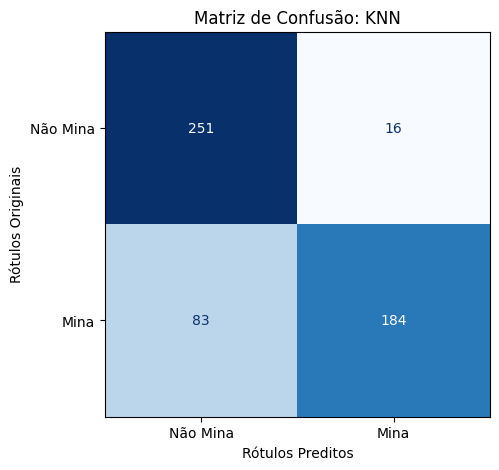

1 -- Árvore de decisão --         acc: 94.39% rec: 92.45% Best parameters {'criterion': 'entropy', 'max_depth': 7}
2 -- Árvore de decisão --         acc: 92.52% rec: 88.68% Best parameters {'criterion': 'entropy', 'max_depth': 7}
3 -- Árvore de decisão --         acc: 93.46% rec: 90.74% Best parameters {'criterion': 'gini', 'max_depth': 7}
4 -- Árvore de decisão --         acc: 93.46% rec: 90.74% Best parameters {'criterion': 'gini', 'max_depth': 7}
5 -- Árvore de decisão --         acc: 90.57% rec: 84.91% Best parameters {'criterion': 'entropy', 'max_depth': 7}

	A média de acuracia do Árvore de decisão foi de 92.87956268735672%
	A média de recall do Árvore de decisão foi de 89.50384346610761%
--------------------------------


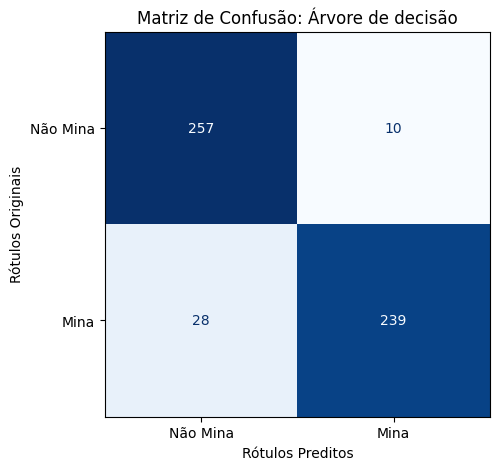

1 -- RandomForest --         acc: 92.52% rec: 84.91% Best parameters {'criterion': 'entropy', 'max_depth': 7, 'n_estimators': 1000}
2 -- RandomForest --         acc: 90.65% rec: 84.91% Best parameters {'criterion': 'gini', 'max_depth': 7, 'n_estimators': 100}
3 -- RandomForest --         acc: 94.39% rec: 90.74% Best parameters {'criterion': 'entropy', 'max_depth': 7, 'n_estimators': 100}
4 -- RandomForest --         acc: 98.13% rec: 96.3% Best parameters {'criterion': 'entropy', 'max_depth': 7, 'n_estimators': 500}
5 -- RandomForest --         acc: 91.51% rec: 90.57% Best parameters {'criterion': 'entropy', 'max_depth': 7, 'n_estimators': 100}

	A média de acuracia do RandomForest foi de 93.44207370834067%
	A média de recall do RandomForest foi de 89.48287910552061%
--------------------------------


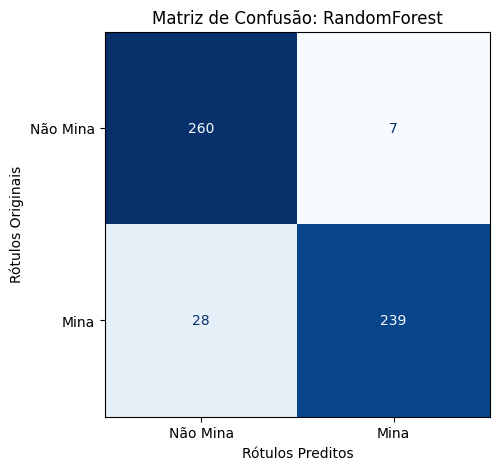

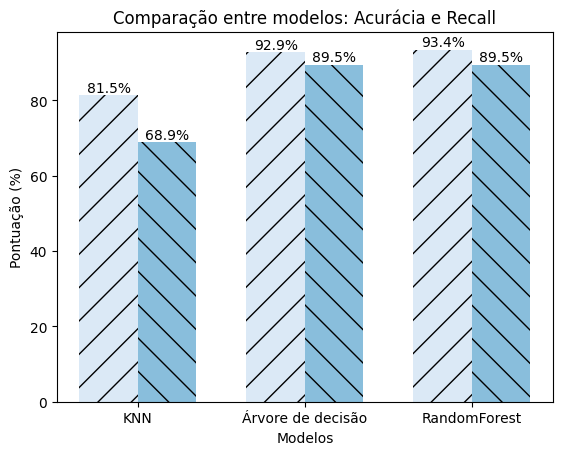

In [36]:
X = new_df[["Voltage", "Height", "Soil Type"]].to_numpy()
y = new_df['Mine Type']

kf = StratifiedKFold(shuffle=True)

model_performance = []

for model_name, (clf, parameters) in model.items():
    means = {'accuracy': [], 'recall': []}
    confusion_matrices = []
    
    for fold, (train,test) in enumerate(kf.split(X,y)):
        best = GridSearchCV(clf, parameters, n_jobs=-1, cv=kf, scoring="recall", return_train_score=True)
        best.fit(X[train], y[train])
        
        y_pred = best.predict(X[test])
        
        means['accuracy'].append(accuracy_score(y[test], y_pred))
        means['recall'].append(recall_score(y[test], y_pred))
        
        confusion_matrices.append(confusion_matrix(y[test], y_pred))
        
        print(f"{fold+1} -- {model_name} -- \
        acc: {round(means['accuracy'][-1] * 100, 2)}% rec: {round(means['recall'][-1] * 100, 2)}% Best parameters {best.best_params_}")
    
    avg_accuracy = sum(means['accuracy']) / len(means['accuracy']) * 100
    avg_recall = sum(means['recall']) / len(means['recall']) * 100
    
    print(f"\n\tA média de acuracia do {model_name} foi de {avg_accuracy}%")
    print(f"\tA média de recall do {model_name} foi de {avg_recall}%")
    print("--------------------------------")
    
    aggregate_confusion_matrix = np.sum(confusion_matrices, axis=0)
    fig3, ax3 = plt.subplots(figsize=(10, 5), dpi=100)
    

    disp = ConfusionMatrixDisplay(aggregate_confusion_matrix, display_labels=["Não Mina", "Mina"])
    disp.plot(ax=ax3, colorbar=False, cmap=plt.cm.Blues, values_format=".0f")

    plt.imshow(aggregate_confusion_matrix, interpolation='nearest', cmap="Blues")
    plt.colorbar().remove()
    
    ax3.set_title(f"Matriz de Confusão: {model_name}")
    ax3.set_xlabel("Rótulos Preditos")
    ax3.set_ylabel("Rótulos Originais")
    
    plt.show()
    
    model_performance.append({'Model': model_name, 'Accuracy': avg_accuracy, 'Recall': avg_recall})

models_df = pd.DataFrame(model_performance)
bar_width = 0.35
index = np.arange(len(model_performance))

fig, ax = plt.subplots()

sns.set_palette("Blues")

rects1 = ax.bar(index, models_df['Accuracy'], bar_width, label='Accuracy', hatch='/', color=sns.color_palette()[0])
rects2 = ax.bar(index + bar_width, models_df['Recall'], bar_width, label='Recall', hatch='\\', color=sns.color_palette()[2])

ax.set_xlabel('Modelos')
ax.set_ylabel('Pontuação (%)')
ax.set_title('Comparação entre modelos: Acurácia e Recall')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(models_df['Model'])

for i, rect in enumerate(rects1):
    ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height(), f"{round(models_df['Accuracy'][i], 1)}%", ha='center', va='bottom')

for i, rect in enumerate(rects2):
    ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height(), f"{round(models_df['Recall'][i], 1)}%", ha='center', va='bottom')


plt.show()

# Buscando os melhores hiperparâmetros para o modelo de Random Forest

In [31]:
params = {
    'n_estimators' : [50, 100, 150, 500],
    'max_depth'    : [None, 3, 5, 7, 9, 11, 13, 15],
    'class_weight' : [None, 'balanced', 'balanced_subsample'],
    'criterion'    : ['gini', 'entropy'],
    'max_features' : [None, 'sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'oob_score': [False, True],
}

In [32]:
best = GridSearchCV(RandomForestClassifier(), params, n_jobs=-1, cv=kf, scoring="recall", return_train_score=True)
best.fit(X, y)

print("\n O Melhor estimador:\n", best.best_estimator_)
print("\n O melhor score:\n", best.best_score_)
print("\n Os melhores parametros:\n", best.best_params_)

KeyboardInterrupt: 

In [ ]:
X = new_df[["Voltage", "Height", "Soil Type"]].to_numpy()
y = new_df['Mine Type']

kf = StratifiedKFold(shuffle=True)

fig, ax = plt.subplots(figsize=(10, 10))
ax.plot([0, 1], [0, 1], "k--", label="Nível de Chance (AUC = 0.5)")
    
means = {'accuracy': [], 'recall': []}
confusion_matrices = []

clf = RandomForestClassifier(criterion='entropy', max_depth=15, max_features='log2', min_samples_split=5, n_estimators=50, oob_score=True)

for fold, (train,test) in enumerate(kf.split(X,y)):
    clf.fit(X[train], y[train])

    y_pred = clf.predict(X[test])

    accuracy = accuracy_score(y[test], y_pred)
    recall = recall_score(y[test], y_pred)

    print(f"fold: {fold + 1}\t acc: {accuracy * 100}\t rec: {recall * 100}")

    means['accuracy'].append(accuracy)
    means['recall'].append(recall)

    confusion_matrices.append(confusion_matrix(y[test], y_pred))

    viz = RocCurveDisplay.from_estimator(
        clf,
        X[test],
        y[test],
        name=f"ROC Iteração {fold + 1}",
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    
    ax.set_xlabel("Taxa de Falso Positivo (Tipo Positivo de Mina: 1)")
    ax.set_ylabel("Taxa de Verdadeiro Positivo")

    fig2, ax2 = plt.subplots(figsize=(10, 5))
    ConfusionMatrixDisplay.from_predictions(y[test], y_pred, ax=ax2, display_labels=["Não Mina", "Mina"])
    ax2.set_title(f"Matriz de Confusão - Iteração {fold + 1}")
    ax2.set_xlabel("Rótulos Preditos")
    ax2.set_ylabel("Rótulos Originais")
    
aggregate_confusion_matrix = np.sum(confusion_matrices, axis=0)
fig3, ax3 = plt.subplots(figsize=(10, 5), dpi=100)
    
disp = ConfusionMatrixDisplay(aggregate_confusion_matrix, display_labels=["Não Mina", "Mina"])
disp.plot(ax=ax3, colorbar=False, cmap=plt.cm.Blues, values_format=".0f")

plt.imshow(aggregate_confusion_matrix, interpolation='nearest', cmap="Blues")
plt.colorbar().remove()

ax3.set_title(f"Matriz de Confusão: {model_name}")
ax3.set_xlabel("Rótulos Preditos")
ax3.set_ylabel("Rótulos Originais")

plt.show()

print(f"\nAccuracy Score\t {sum(means['accuracy']) / len(means['accuracy']) * 100}")
print(f"Recall Score\t {sum(means['recall']) / len(means['recall']) * 100}")

# Treinamento final e Exportação da Inteligência Artificial

In [ ]:
clf = RandomForestClassifier(criterion='entropy', max_depth=15, max_features='log2', min_samples_split=5, n_estimators=50, oob_score=True)
clf.fit(X, y)

In [ ]:
filename = "model.pkl"
with open(filename, 'wb') as file:
    pickle.dump(clf, file)